In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ─── Cell 1: Install & Imports ───
# We need scikit-learn, imbalanced-learn for SMOTE, and geopandas/f

!pip install --quiet scikit-learn imbalanced-learn geopandas folium geopy

import pandas as pd
import numpy as np

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', font_scale=1.1)
%matplotlib inline

# machine learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree         import DecisionTreeClassifier, plot_tree
from sklearn.ensemble     import RandomForestClassifier
from sklearn.metrics      import classification_report, f1_score, silhouette_score

# preprocessing & imbalance
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTENC

# clustering & mapping
from sklearn.cluster import KMeans, DBSCAN
import geopandas as gpd
from geopy.geocoders import Nominatim
import folium


In [ ]:
# ─── Cell 2: Load and Peek at the Data ───
df = pd.read_csv('/content/drive/MyDrive/Business analytics/cais_dati.csv', sep=';', encoding='utf-8-sig')
print(f"Data shape: {df.shape}")
df.head()


<ipython-input-3-d3b7ca2aba16>:2: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/Business analytics/cais_dati.csv', sep=';', encoding='utf-8-sig')


Data shape: (691763, 28)


,Notikuma kārtas nr,Datums,Dalībnieka vecums,Dalībnieka miesas bojājumi,Notikuma vieta Novads,Notikuma vieta Pilsēta,Notikuma vieta Ciems,Notikuma vieta Iela,Notikuma vieta Mājas nr,Notikuma vieta Korpusa nr,...,Vieta,Reibums,CSNg veids,Iemesli,Laika apstākļi,Seguma veids,Brauktuves stāvoklis,Ceļa apstākļi,Apgaismojums,Papildus raksturojums
0,1_2013,01.01.2013,28,NAV CIETIS,NaN,RĪGA,NaN,LAUKU,1,NaN,...,POSMS,REIBUMS NAV KONSTATĒTS,UZBRAUKŠANA ŠĶĒRSLIM,NENOSKAIDROTS IEMESLS,SKAIDRS,DAŽĀDS,SLAPJA,NaN,DIENA,AR CEĻA ZĪMĒM REGUL. KRUSTOJUMS
1,1_2013,02.01.2013,18,VIEGLI IEVAINOTS,NaN,RĪGA,NaN,LAUKU,1,NaN,...,POSMS,REIBUMS IR KONSTATĒTS,UZBRAUKŠANA ŠĶĒRSLIM,NENOSKAIDROTS IEMESLS,SKAIDRS,DAŽĀDS,SLAPJA,NaN,DIENA,AR CEĻA ZĪMĒM REGUL. KRUSTOJUMS
2,2_2013,03.01.2013,38,VIEGLI IEVAINOTS,BAUSKAS NOVADS,BAUSKA,NaN,ĪSLĪCES,10,NaN,...,POSMS,REIBUMS NAV KONSTATĒTS,UZBRAUKŠANA GĀJĒJAM,ŠĶĒRSO CEĻU TUVU BR. TR. PRIEKŠĀ,LIETUS,ASFALTBETONS,SLAPJA,NaN,TUMSA,"IELAS, CEĻA POSMS"
3,2_2013,04.01.2013,22,NAV CIETIS,BAUSKAS NOVADS,BAUSKA,NaN,ĪSLĪCES,10,NaN,...,POSMS,REIBUMS NAV KONSTATĒTS,UZBRAUKŠANA GĀJĒJAM,ŠĶĒRSO CEĻU TUVU BR. TR. PRIEKŠĀ,LIETUS,ASFALTBETONS,SLAPJA,NaN,TUMSA,"IELAS, CEĻA POSMS"
4,3_2013,01.01.2013,59,NAV CIETIS,NaN,RĪGA,NaN,MĀRUPES,NaN,NaN,...,KRUSTOJUMS,REIBUMS NAV KONSTATĒTS,SADURSME,NENOSKAIDROTS IEMESLS,APMĀCIES,ASFALTBETONS,SLAPJA,NaN,"TUMSA, APGAISM.IESLĒGTS",AR CEĻA ZĪMĒM REGUL. KRUSTOJUMS


In [ ]:
# ─── Cell 3: Rename & Time Features ───

# Rename the key Latvian columns into English
df = df.rename(columns={
    "Datums":                     "Date",
    "Dalībnieka vecums":          "Age",
    "Dalībnieka miesas bojājumi": "InjurySeverity",
    "Reibums":                    "Alcohol",
    "Seguma veids":               "RoadSurface",
    "Apvidus":                    "AreaType",
    "Notikuma vieta Pilsēta":     "City",
    "Notikuma vieta Iela":        "Street"
})

# Parse the accident timestamp and extract the hour
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce')
df['Hour'] = df['Date'].dt.hour

# Encode hour as cyclic features (so 23:00 and 0:00 are close)
df['Hour_sin'] = np.sin(2*np.pi * df['Hour'] / 24)
df['Hour_cos'] = np.cos(2*np.pi * df['Hour'] / 24)

df.head()

,Notikuma kārtas nr,Date,Age,InjurySeverity,Notikuma vieta Novads,City,Notikuma vieta Ciems,Street,Notikuma vieta Mājas nr,Notikuma vieta Korpusa nr,...,Iemesli,Laika apstākļi,RoadSurface,Brauktuves stāvoklis,Ceļa apstākļi,Apgaismojums,Papildus raksturojums,Hour,Hour_sin,Hour_cos
0,1_2013,2013-01-01,28,NAV CIETIS,NaN,RĪGA,NaN,LAUKU,1,NaN,...,NENOSKAIDROTS IEMESLS,SKAIDRS,DAŽĀDS,SLAPJA,NaN,DIENA,AR CEĻA ZĪMĒM REGUL. KRUSTOJUMS,0.0,0.0,1.0
1,1_2013,2013-01-02,18,VIEGLI IEVAINOTS,NaN,RĪGA,NaN,LAUKU,1,NaN,...,NENOSKAIDROTS IEMESLS,SKAIDRS,DAŽĀDS,SLAPJA,NaN,DIENA,AR CEĻA ZĪMĒM REGUL. KRUSTOJUMS,0.0,0.0,1.0
2,2_2013,2013-01-03,38,VIEGLI IEVAINOTS,BAUSKAS NOVADS,BAUSKA,NaN,ĪSLĪCES,10,NaN,...,ŠĶĒRSO CEĻU TUVU BR. TR. PRIEKŠĀ,LIETUS,ASFALTBETONS,SLAPJA,NaN,TUMSA,"IELAS, CEĻA POSMS",0.0,0.0,1.0
3,2_2013,2013-01-04,22,NAV CIETIS,BAUSKAS NOVADS,BAUSKA,NaN,ĪSLĪCES,10,NaN,...,ŠĶĒRSO CEĻU TUVU BR. TR. PRIEKŠĀ,LIETUS,ASFALTBETONS,SLAPJA,NaN,TUMSA,"IELAS, CEĻA POSMS",0.0,0.0,1.0
4,3_2013,2013-01-01,59,NAV CIETIS,NaN,RĪGA,NaN,MĀRUPES,NaN,NaN,...,NENOSKAIDROTS IEMESLS,APMĀCIES,ASFALTBETONS,SLAPJA,NaN,"TUMSA, APGAISM.IESLĒGTS",AR CEĻA ZĪMĒM REGUL. KRUSTOJUMS,0.0,0.0,1.0


In [ ]:
# ─── Cell 4: Cleaning the Data ───

# Fill missing datas with “Unknown”
for col in ['RoadSurface','AreaType','City','Street']:
    if col in df.columns:
        df[col] = df[col].fillna('Unknown')

# Drop any rows which are not havinng date, age, or injury recorded
initial = len(df)
df = df.dropna(subset=['Date','Age','InjurySeverity'])
print(f"Dropped {initial - len(df)} rows; {len(df)} remain.")


Dropped 303283 rows; 388480 remain.


In [ ]:
# ─── Cell 5: Map Severity & Engineer Features ───

# Convert Age to numeric (bad entries → NaN)
df['Age'] = pd.to_numeric(df['Age'], errors='coerce')

# Map InjurySeverity to integer labels
severity_map = {
    'NAV CIETIS':       0,  # no injury
    'VIEGLI IEVAINOTS': 1,  # minor
    'SMAGI IEVAINOTS':  2,  # severe
    'GĀJUŠI BOJĀ':      3   # fatal
}
df['y'] = df['InjurySeverity'].map(severity_map)

# Alcohol flag (1 if detected)
df['AlcoholFlag'] = df['Alcohol'].apply(
    lambda x: 1 if isinstance(x, str) and 'IR KONSTATĒTS' in x else 0
)

# Add month, weekday, and weekend flag
df['Month']     = df['Date'].dt.month
df['Weekday']   = df['Date'].dt.dayofweek
df['IsWeekend'] = df['Weekday'].isin([5,6]).astype(int)

df[['Age','y','AlcoholFlag','Month','Weekday','IsWeekend']].head()


,Age,y,AlcoholFlag,Month,Weekday,IsWeekend
0,28.0,0.0,0,1,1,0
1,18.0,1.0,1,1,2,0
2,38.0,1.0,0,1,3,0
3,22.0,0.0,0,1,4,0
4,59.0,0.0,0,1,1,0


from matplotlib import pyplot as plt
_df_0['Age'].plot(kind='hist', bins=20, title='Age')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['y'].plot(kind='hist', bins=20, title='y')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['AlcoholFlag'].plot(kind='hist', bins=20, title='AlcoholFlag')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['Weekday'].plot(kind='hist', bins=20, title='Weekday')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='Age', y='y', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='y', y='AlcoholFlag', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='AlcoholFlag', y='Weekday', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Month']
  ys = series['Age']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_7.sort_values('Month', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Month')
_ = plt.ylabel('Age')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Month']
  ys = series['y']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('Month', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Month')
_ = plt.ylabel('y')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Month']
  ys = series['AlcoholFlag']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('Month', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Month')
_ = plt.ylabel('AlcoholFlag')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Month']
  ys = series['Weekday']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('Month', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Month')
_ = plt.ylabel('Weekday')

from matplotlib import pyplot as plt
_df_11['Age'].plot(kind='line', figsize=(8, 4), title='Age')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_12['y'].plot(kind='line', figsize=(8, 4), title='y')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_13['AlcoholFlag'].plot(kind='line', figsize=(8, 4), title='AlcoholFlag')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['Weekday'].plot(kind='line', figsize=(8, 4), title='Weekday')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
# ─── Cell 6: Build Feature Matrix ───

# 1. Numeric columns
numeric_cols = ['Age','Hour_sin','Hour_cos','AlcoholFlag','Month','Weekday','IsWeekend']

# 2. One-hot encode small-cardinality cats
cat_cols = [c for c in ['RoadSurface','AreaType'] if c in df.columns]
encoder  = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
cat_matrix = encoder.fit_transform(df[cat_cols]) if cat_cols else np.empty((len(df),0))
cat_features = encoder.get_feature_names_out(cat_cols).tolist() if cat_cols else []

# 3. Combine numeric + cat matrix
X_all = np.hstack([df[numeric_cols].values, cat_matrix])

# 4. Align with target, drop any rows with NaNs
mask = (~np.isnan(X_all).any(axis=1)) & (~df['y'].isna())
X = X_all[mask]
y = df.loc[mask, 'y'].astype(int).values

print("Features shape:", X.shape)
print("Final feature list:", numeric_cols + cat_features)


Features shape: (361553, 14)
Final feature list: ['Age', 'Hour_sin', 'Hour_cos', 'AlcoholFlag', 'Month', 'Weekday', 'IsWeekend', 'RoadSurface_BRUĢIS', 'RoadSurface_CEMENTBETONS', 'RoadSurface_DAŽĀDS', 'RoadSurface_GRANTS', 'RoadSurface_GRUNTS', 'RoadSurface_Unknown', 'RoadSurface_ŠĶEMBAS']


In [ ]:
# ─── Cell 7: Split & Baseline Models ───

# 20% test split, stratified by severity
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# (a) Decision Tree baseline
tree = DecisionTreeClassifier(class_weight='balanced', random_state=42)
tree.fit(X_train, y_train)
pred_tree = tree.predict(X_test)
print("Decision Tree F1:", f1_score(y_test, pred_tree, average='weighted'))

# (b) Random Forest baseline
forest = RandomForestClassifier(
    n_estimators=100, max_features='sqrt',
    class_weight='balanced', random_state=42, n_jobs=-1
)
forest.fit(X_train, y_train)
pred_rf = forest.predict(X_test)
print("Random Forest F1:", f1_score(y_test, pred_rf, average='weighted'))


Decision Tree F1: 0.5854201529857309
Random Forest F1: 0.6688438775739383


In [ ]:
# ─── Cell 8: RandomizedSearchCV on Random Forest ───
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Define broad distributions for 10 random draws
param_dist = {
    'n_estimators':      randint(50, 201),  # 50–200 trees
    'max_depth':         randint(5, 31),    # depth 5–30
    'min_samples_leaf':  randint(1, 11)     # leaf size 1–10
}

rand_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    ),
    param_distributions=param_dist,
    n_iter=12,            # only 12 sampled combos
    cv=3,
    scoring='f1_weighted',
    verbose=1,
    n_jobs=-1,
    random_state=42
)
rand_search.fit(X_train, y_train)

print("Best RF params:", rand_search.best_params_)
print("RF Randomized F1:", f1_score(y_test, rand_search.predict(X_test), average='weighted'))


Fitting 3 folds for each of 12 candidates, totalling 36 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best RF params: {'max_depth': 14, 'min_samples_leaf': 3, 'n_estimators': 157}
RF Randomized F1: 0.73147144121624


In [ ]:
final_rf = RandomForestClassifier(
    n_estimators=157,
    max_depth=14,
    min_samples_leaf=3,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
final_rf.fit(X_train, y_train)
print("Final RF F1:", f1_score(y_test, final_rf.predict(X_test), average='weighted'))


Final RF F1: 0.73147144121624


In [ ]:
cat_feats = []            # no categorical columns
raw_cols  = numeric_feats # just the 7 you know exist


In [ ]:
# 1) Prepare df_raw
df_raw = df.dropna(subset=['y'] + raw_cols).reset_index(drop=True)
Xn     = df_raw[numeric_feats]
yn     = df_raw['y']

# 2) Train-test split
from sklearn.model_selection import train_test_split
Xn_train, Xn_test, yn_train, yn_test = train_test_split(
    Xn, yn, test_size=0.2, stratify=yn, random_state=42
)

# 3) Build a pipeline that just passes through the 7 numeric
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[('num','passthrough',numeric_feats)],
    remainder='drop'
)

pipeline = Pipeline([
    ('preproc', preprocessor),
    ('rf', final_rf)   # or retrain final_rf_small here if you like
])

# 4) Fit & dump
pipeline.fit(Xn_train, yn_train)
import joblib
joblib.dump(pipeline, 'rf_pipeline.pkl')
print("Pipeline on numeric-only saved.")


Pipeline on numeric-only saved.


In [ ]:
# ─── Cell 10.1: Setup MiniBatchKMeans ───

from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics  import silhouette_score
import matplotlib.pyplot as plt

# Tune these for speed vs quality
batch_size   = 2000    # only 2 k rows per mini‐batch
n_init       = 1       # single random start
max_iter     = 100     # 100 mini‐batch updates
init_size    = batch_size * 3
random_state = 42

print("MiniBatchKMeans ready with batch_size =", batch_size)


MiniBatchKMeans ready with batch_size = 2000


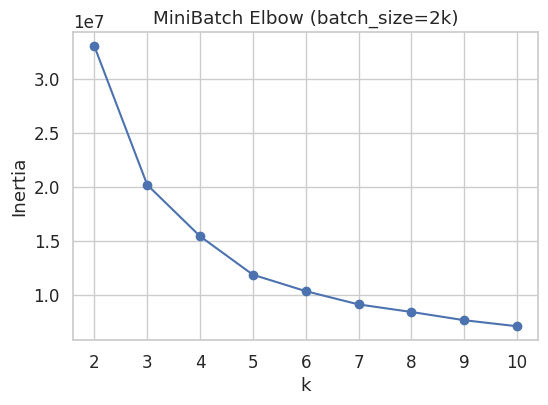

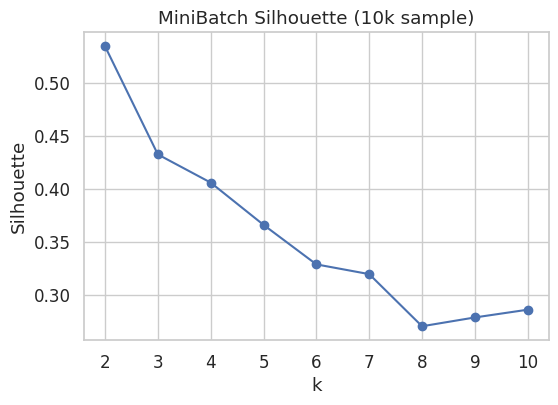

In [ ]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics  import silhouette_score
import numpy as np
import matplotlib.pyplot as plt

# draw a 10 k‐row sample for silhouette
sample_idx = np.random.choice(X.shape[0], size=10000, replace=False)
X_samp     = X[sample_idx]

ks = range(2,11)
inertias, sil_scores = [], []

for k in ks:
    mbk = MiniBatchKMeans(
        n_clusters   = k,
        batch_size   = batch_size,
        max_iter     = max_iter,
        n_init       = n_init,
        init_size    = init_size,
        random_state = random_state
    ).fit(X)  # only fitting centroids, still on full X

    inertias.append(mbk.inertia_)

    # use only the sampled points for silhouette scoring
    labels_samp = mbk.labels_[sample_idx]
    sil_scores.append(silhouette_score(X_samp, labels_samp))

# Plot inertia
plt.figure(figsize=(6,4))
plt.plot(ks, inertias, 'o-')
plt.title('MiniBatch Elbow (batch_size=2k)'); plt.xlabel('k'); plt.ylabel('Inertia')
plt.show()

# Plot silhouette
plt.figure(figsize=(6,4))
plt.plot(ks, sil_scores, 'o-')
plt.title('MiniBatch Silhouette (10k sample)'); plt.xlabel('k'); plt.ylabel('Silhouette')
plt.show()


In [ ]:
# Recreate the same mask you used for X
mask = (~np.isnan(X_all).any(axis=1)) & (~df['y'].isna())

# Make a df just for clustering
df_cluster = df[mask].copy()

# Fit & assign clusters
k_opt = 4
mbk_final = MiniBatchKMeans(
    n_clusters   = k_opt,
    batch_size   = 2000,
    max_iter     = 100,
    n_init       = 1,
    init_size    = 6000,
    random_state = 42
)
df_cluster['Cluster'] = mbk_final.fit_predict(X)

# Now profile on df_cluster
cluster_summary = df_cluster.groupby('Cluster').agg({
    'Age':         ['mean','median'],
    'Hour':        'median',
    'AlcoholFlag': 'mean',
    'RoadSurface': lambda s: s.mode()[0]
})
display(cluster_summary)


Age          Hour AlcoholFlag   RoadSurface
              mean median median        mean      <lambda>
Cluster                                                   
0        56.292722   56.0    0.0    0.030490  ASFALTBETONS
1        25.302830   26.0    0.0    0.035985  ASFALTBETONS
2        41.052439   41.0    0.0    0.034889  ASFALTBETONS
3        72.367294   71.0    0.0    0.017709  ASFALTBETONS

<ipython-input-19-255ccf82f44c>:25: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


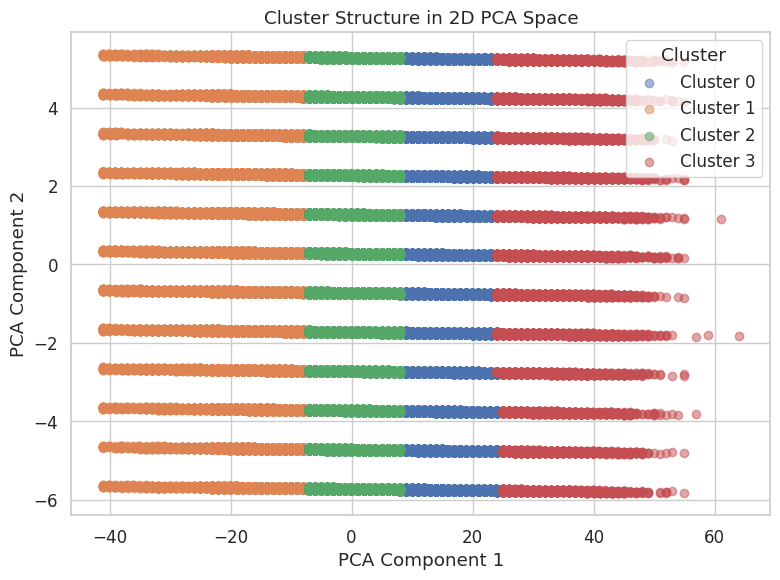

In [ ]:
# ─── Visualize Cluster Structure with PCA ───
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# 1) Reduce X to 2 dimensions with PCA
pca = PCA(n_components=2, random_state=42)
X_2d = pca.fit_transform(X)  # X is your full feature matrix

# 2) Scatter‐plot the two principal components, coloring by cluster
plt.figure(figsize=(8,6))
for cid in sorted(df_cluster['Cluster'].unique()):
    mask = (df_cluster['Cluster'] == cid)
    plt.scatter(
        X_2d[mask, 0],
        X_2d[mask, 1],
        label=f'Cluster {cid}',
        alpha=0.5
    )

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Cluster Structure in 2D PCA Space')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()


In [ ]:
CACHE_FILE = 'city_coords.pkl'
df['City'] = df['City'].fillna('Unknown')
freq       = df['City'].value_counts()
top_cities = set(freq.head(50).index)
df['City_bin'] = df['City'].where(df['City'].isin(top_cities), 'Other')
unique_cities = df['City_bin'].unique().tolist()

if os.path.exists(CACHE_FILE):
    with open(CACHE_FILE, 'rb') as f:
        city_coords = pickle.load(f)
else:
    city_coords = {}
geolocator = Nominatim(user_agent="city_geocoder", timeout=10)
geocode     = RateLimiter(geolocator.geocode, min_delay_seconds=1, max_retries=2)

for city in unique_cities:
    if city not in city_coords:
        if city == 'Other':

            city_coords[city] = (56.8796, 24.6032)
        else:
            loc = geocode(f"{city}, Latvia")
            city_coords[city] = (loc.latitude, loc.longitude) if loc else (pd.NA, pd.NA)


with open(CACHE_FILE, 'wb') as f:
    pickle.dump(city_coords, f)
df['lat'] = df['City_bin'].map(lambda c: city_coords[c][0])
df['lon'] = df['City_bin'].map(lambda c: city_coords[c][1])
before = len(df)
df = df.dropna(subset=['lat','lon']).reset_index(drop=True)
print(f"Using top-50 geocode → dropped {before - len(df)} rows; {len(df)} remain.")


Using top-50 geocode → dropped 0 rows; 388480 remain.


In [ ]:
# ─── Verify geocoding ───
print("Columns in df:", df.columns.tolist())
print("\nSample of lat/lon values:")
print(df[['lat','lon']].head(10))
print("\nlat/lon not-null counts:")
print(df[['lat','lon']].notna().sum())


Columns in df: ['Notikuma kārtas nr', 'Date', 'Age', 'InjurySeverity', 'Notikuma vieta Novads', 'City', 'Notikuma vieta Ciems', 'Street', 'Notikuma vieta  Mājas nr', 'Notikuma vieta Korpusa nr ', 'Notikuma vieta Krustojums ar ielu', 'Notikuma vieta Ceļš', 'Notikuma vieta Krustojums ar ceļu', 'Notikuma vieta Ceļa attālums km', 'Notikuma vieta Tilts', 'Notikuma vieta Māja txt', 'Notikuma vieta Iela txt', 'Notikuma vieta Krustojums ar ielu txt', 'Vieta', 'Alcohol', 'CSNg veids', 'Iemesli', 'Laika apstākļi', 'RoadSurface', 'Brauktuves stāvoklis', 'Ceļa apstākļi', 'Apgaismojums', 'Papildus raksturojums', 'Hour', 'Hour_sin', 'Hour_cos', 'y', 'AlcoholFlag', 'Month', 'Weekday', 'IsWeekend', 'City_bin', 'lat', 'lon']

Sample of lat/lon values:
         lat        lon
0  56.949398  24.105185
1  56.949398  24.105185
2  56.408286  24.187667
3  56.408286  24.187667
4  56.949398  24.105185
5  56.949398  24.105185
6  56.949398  24.105185
7  56.949398  24.105185
8  56.949398  24.105185
9  56.833112  2

In [ ]:
# ─── Lean DBSCAN via 20 000-point Sampling ───
import numpy as np
from sklearn.cluster import DBSCAN
from pyproj import Transformer
import folium

# 1) Draw a 15 000-row sample
N = 20000
idx_samp = np.random.choice(df.index, size=N, replace=False)
df_samp  = df.loc[idx_samp].reset_index(drop=True)

# 2) Project lon/lat → meters
tf     = Transformer.from_crs("EPSG:4326", "EPSG:3059", always_xy=True)
xs, ys = tf.transform(df_samp.lon.values, df_samp.lat.values)
coords = np.column_stack([xs, ys])

# 3) Run DBSCAN on that sample
db     = DBSCAN(eps=250, min_samples=5, n_jobs=-1)
labels = db.fit_predict(coords)
df_samp['hotspot'] = labels

# 4) Show cluster sizes
print("DBSCAN cluster counts on 15 000 sample:")
print(df_samp['hotspot'].value_counts().sort_index())

# 5) Save a quick map (hotspots in red)
m = folium.Map(location=[df_samp.lat.mean(), df_samp.lon.mean()], zoom_start=10)
for _,r in df_samp.iterrows():
    color = 'red' if r.hotspot != -1 else 'lightgray'
    folium.CircleMarker((r.lat, r.lon), radius=2, color=color, fill=True).add_to(m)
m.save('hotspots_15k.html')
print("→ hotspots_15k.html")


In [ ]:
# ─── Cell X: HDBSCAN on 20 000-Point Sample ───
!pip install --quiet hdbscan

import numpy as np
import hdbscan
from pyproj import Transformer
import folium

# 1) Sample 20 000 rows
N = 20000
idx_samp = np.random.choice(df.index, size=N, replace=False)
df_samp  = df.loc[idx_samp].reset_index(drop=True)

# 2) Project lon/lat → meters
tf     = Transformer.from_crs("EPSG:4326","EPSG:3059",always_xy=True)
xs, ys = tf.transform(df_samp.lon.values, df_samp.lat.values)
coords = np.column_stack([xs, ys])

# 3) Fit HDBSCAN
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=50,  # adjust as you like
    min_samples=5,
    core_dist_n_jobs=4
)
labels_h = clusterer.fit_predict(coords)
df_samp['hdbscan'] = labels_h

# 4) Print how many in each cluster
print("HDBSCAN counts (20 000 sample):")
print(pd.Series(labels_h).value_counts().sort_index())

# 5) Quick Folium map
m = folium.Map(location=[df_samp.lat.mean(), df_samp.lon.mean()], zoom_start=10)
for _, r in df_samp.iterrows():
    color = 'red' if r.hdbscan != -1 else 'lightgray'
    folium.CircleMarker((r.lat, r.lon), radius=2, color=color, fill=True).add_to(m)
m.save('hdbscan_sample.html')
print("→ hdbscan_sample.html saved")


In [ ]:
# If Age got accidentally cast to object or filled with zeros, convert it:
df['Age'] = pd.to_numeric(df['Age'], errors='coerce')

# Drop any rows with missing age or missing label
df = df.dropna(subset=['Age','y']).copy()

# Map numeric severity → human names
sev_map = {0: 'No Injury', 1: 'Minor', 2: 'Severe', 3: 'Fatal'}
df['SeverityName'] = df['y'].map(sev_map)


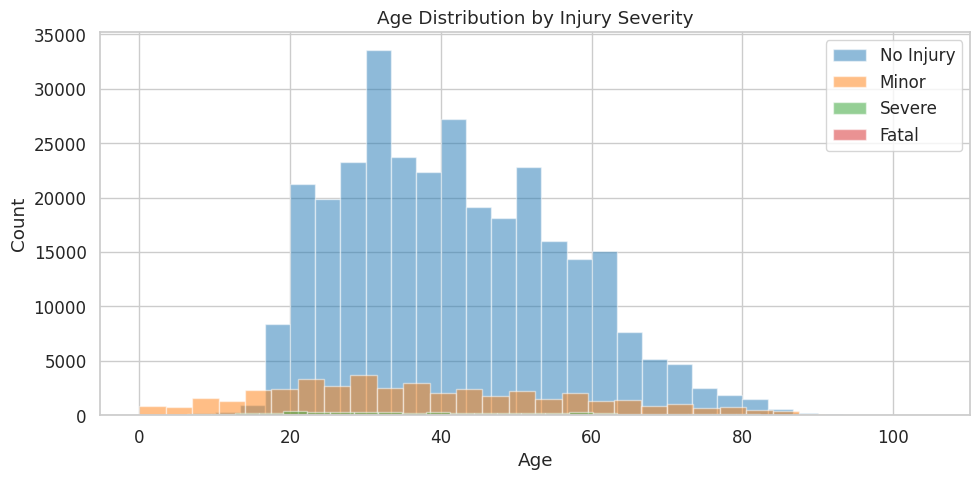

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10,5))
colors = ['tab:blue','tab:orange','tab:green','tab:red']

for (sev, name), c in zip(sev_map.items(), colors):
    ages = df.loc[df['y']==sev, 'Age']
    plt.hist(ages, bins=30, alpha=0.5, label=name, color=c)

plt.title('Age Distribution by Injury Severity')
plt.xlabel('Age')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.show()


<ipython-input-28-fc561524f722>:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=sev_map.values(), patch_artist=True,


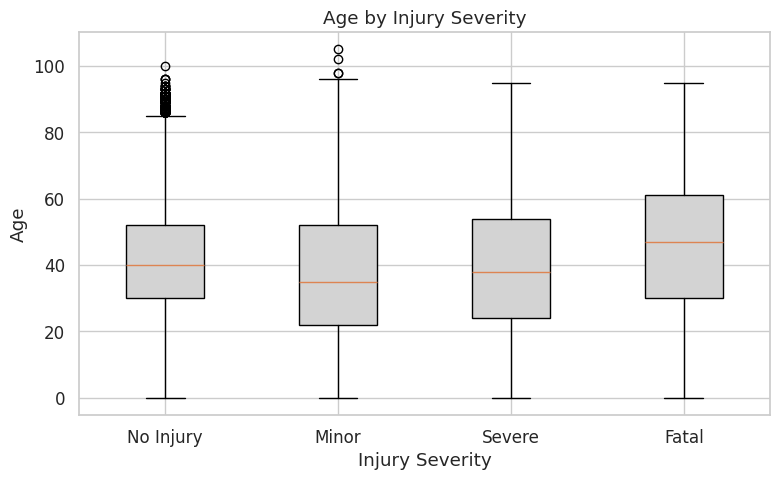

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Map severity codes to names (adjust as needed)
sev_map = {0:'No Injury',1:'Minor',2:'Severe',3:'Fatal'}
df['SeverityName'] = df['y'].map(sev_map)


# 1b) Boxplot
plt.figure(figsize=(8,5))
data = [df.loc[df['SeverityName']==sev, 'Age'] for sev in sev_map.values()]
plt.boxplot(data, labels=sev_map.values(), patch_artist=True,
            boxprops=dict(facecolor='lightgray'))
plt.title('Age by Injury Severity')
plt.xlabel('Injury Severity')
plt.ylabel('Age')
plt.tight_layout()
plt.show()


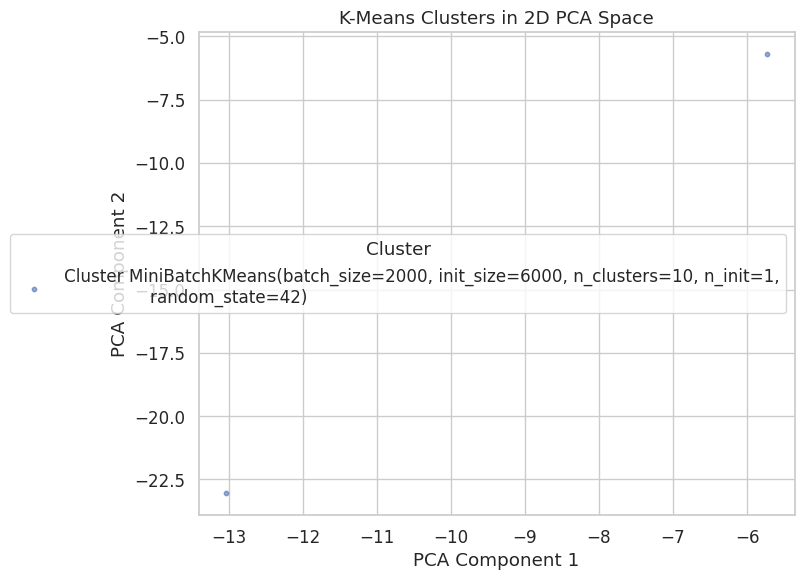

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# X is your feature matrix; clusters is the array of cluster labels
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8,6))
for c in np.unique( mbk):
    mask =  mbk == c
    plt.scatter(X_pca[mask,0], X_pca[mask,1], s=10, alpha=0.6, label=f'Cluster {c}')
plt.legend(title='Cluster')
plt.title('K-Means Clusters in 2D PCA Space')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.tight_layout()
plt.show()


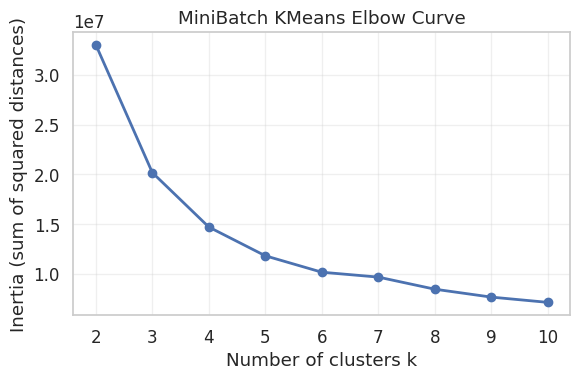

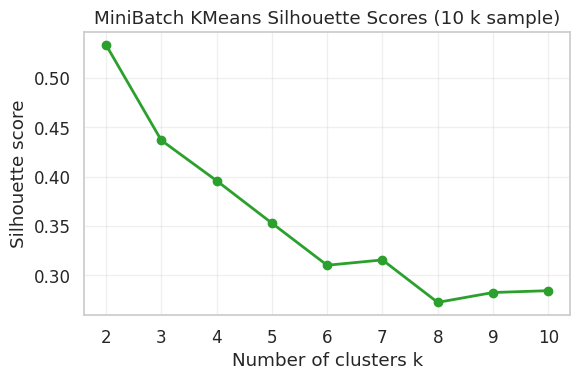

In [ ]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics  import silhouette_score
import numpy as np
import matplotlib.pyplot as plt

# ─── 1) PARAMETERS ─────────────────────────────────────────────────────────────
ks           = range(2,11)      # test k = 2 … 10
batch_size   = 2000             # 2 000 samples per mini‐batch
max_iter     = 100              # iterations per mini‐batch run
n_init       = 10               # number of random restarts
init_size    = batch_size * 3   # initial center‐seeding sample size
random_state = 42

# ─── 2) DRAWS A SMALL SAMPLE FOR SILHOUETTE ────────────────────────────────────
sample_size = 10000
rng         = np.random.default_rng(random_state)
sample_idx  = rng.choice(X.shape[0], size=sample_size, replace=False)
X_samp      = X[sample_idx]

# ─── 3) RUN MINI‐BATCH KMEANS FOR EACH k ───────────────────────────────────────
inertias, sil_scores = [], []
for k in ks:
    mbk = MiniBatchKMeans(
        n_clusters   = k,
        batch_size   = batch_size,
        max_iter     = max_iter,
        n_init       = n_init,
        init_size    = init_size,
        random_state = random_state
    )
    mbk.fit(X)  # centroid update uses mini‐batches, but inertia on full X

    inertias.append(mbk.inertia_)

    # silhouette_score is O(n²) so we only evaluate on the 10 k sample
    labels_samp = mbk.labels_[sample_idx]
    sil = silhouette_score(X_samp, labels_samp)
    sil_scores.append(sil)

# ─── 4) PLOT THE ELBOW (INERTIA) ───────────────────────────────────────────────
plt.figure(figsize=(6,4))
plt.plot(ks, inertias, 'o-', linewidth=2)
plt.xticks(ks)
plt.title('MiniBatch KMeans Elbow Curve')
plt.xlabel('Number of clusters k')
plt.ylabel('Inertia (sum of squared distances)')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ─── 5) PLOT THE SILHOUETTE SCORES ────────────────────────────────────────────
plt.figure(figsize=(6,4))
plt.plot(ks, sil_scores, 'o-', linewidth=2, color='tab:green')
plt.xticks(ks)
plt.title('MiniBatch KMeans Silhouette Scores (10 k sample)')
plt.xlabel('Number of clusters k')
plt.ylabel('Silhouette score')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


<Figure size 600x600 with 0 Axes>

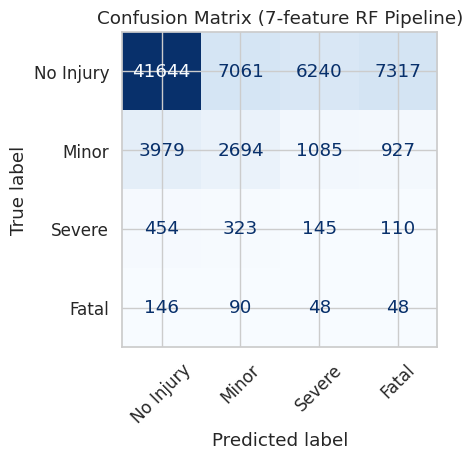

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 1a) Use the pipeline (ColumnTransformer+RF) on your 7-feature test set
#    Xn_test is the DataFrame with exactly the 7 numeric columns
y_pred = pipeline.predict(Xn_test)

# 1b) Build the confusion matrix
labels = ['No Injury','Minor','Severe','Fatal']
cm = confusion_matrix(yn_test, y_pred, labels=[0,1,2,3])

# 1c) Plot it
disp = ConfusionMatrixDisplay(cm, display_labels=labels)
plt.figure(figsize=(6,6))
disp.plot(cmap='Blues', xticks_rotation=45, colorbar=False)
plt.title("Confusion Matrix (7-feature RF Pipeline)")
plt.tight_layout()
plt.show()


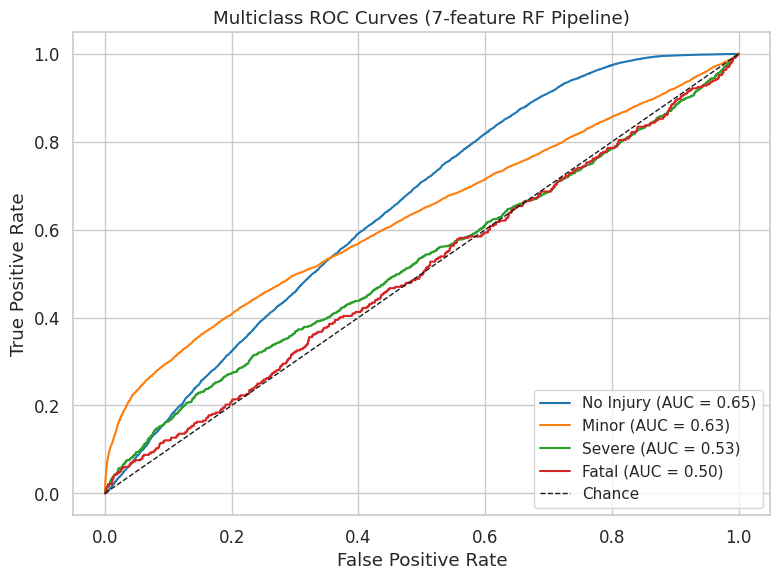

In [ ]:
from sklearn.metrics           import roc_curve, auc
from sklearn.preprocessing     import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# 2a) Binarize the true labels
y_bin = label_binarize(yn_test, classes=[0,1,2,3])

# 2b) Get predicted probabilities from the pipeline
y_proba = pipeline.predict_proba(Xn_test)   # shape = (n_samples, 4)

# 2c) Compute ROC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in [0,1,2,3]:
    fpr[i], tpr[i], _   = roc_curve(y_bin[:, i], y_proba[:, i])
    roc_auc[i]          = auc(fpr[i], tpr[i])

# 2d) Plot
plt.figure(figsize=(8,6))
colors = ['tab:blue','tab:orange','tab:green','tab:red']
for i, col in zip([0,1,2,3], colors):
    plt.plot(fpr[i], tpr[i], color=col,
             label=f'{labels[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0,1],[0,1],'k--', lw=1, label='Chance')
plt.title("Multiclass ROC Curves (7-feature RF Pipeline)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right', fontsize='small')
plt.tight_layout()
plt.show()


In [ ]:
# ─── Extract cluster labels ───
# if you used MiniBatchKMeans or KMeans, e.g.:
# mbk_final = MiniBatchKMeans(n_clusters=4, random_state=42).fit(X)
cluster_labels = mbk_final.labels_


<ipython-input-45-5e4bdeac1c45>:29: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


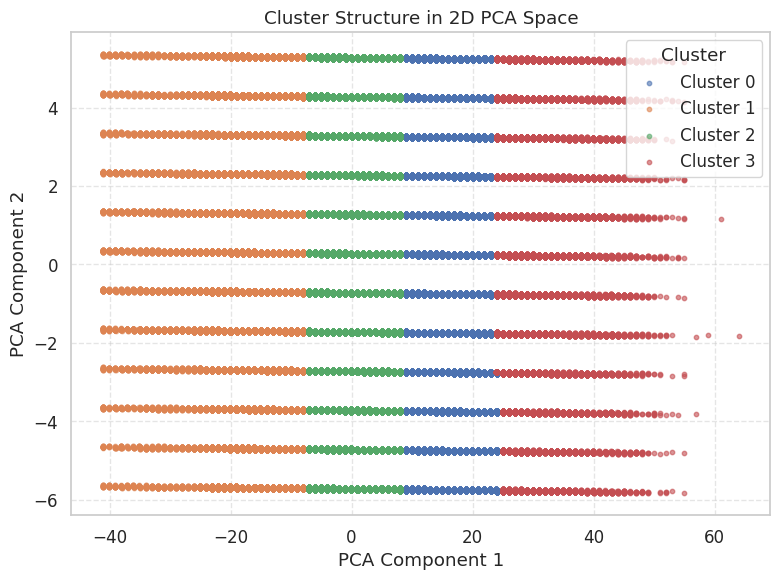

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# make sure cluster_labels is defined
# cluster_labels = mbk_final.labels_

# 1) Project X → 2 principal components
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

# 2) Scatter-plot in PCA space
plt.figure(figsize=(8,6))
for c in np.unique(cluster_labels):
    mask = (cluster_labels == c)
    plt.scatter(
        X_pca[mask, 0],
        X_pca[mask, 1],
        s=10,
        alpha=0.6,
        label=f'Cluster {c}'
    )

plt.legend(title='Cluster')
plt.title('Cluster Structure in 2D PCA Space')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 20000 samples in 0.079s...
[t-SNE] Computed neighbors for 20000 samples in 2.054s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20000
[t-SNE] Computed conditional probabilities for sample 2000 / 20000
[t-SNE] Computed conditional probabilities for sample 3000 / 20000
[t-SNE] Computed conditional probabilities for sample 4000 / 20000
[t-SNE] Computed conditional probabilities for sample 5000 / 20000
[t-SNE] Computed conditional probabilities for sample 6000 / 20000
[t-SNE] Computed conditional probabilities for sample 7000 / 20000
[t-SNE] Computed conditional probabilities for sample 8000 / 20000
[t-SNE] Computed conditional probabilities for sample 9000 / 20000
[t-SNE] Computed conditional probabilities for sample 10000 / 20000
[t-SNE] Computed conditional probabilities for sample 11000 / 20000
[t-SNE] Computed conditional probabilities for sample 12000 / 20000
[t-SNE] Computed conditional probabilities for sam

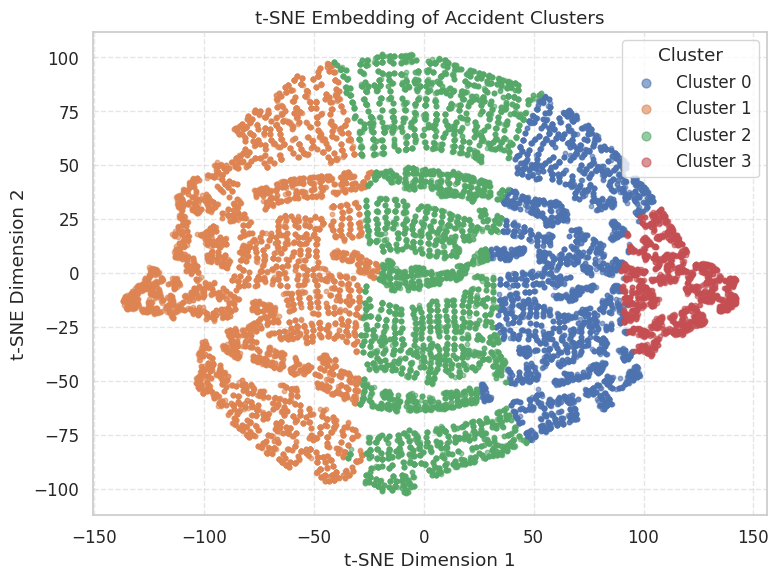

In [ ]:
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt

# 1) Sample for speed
sample_size = 20000
rng = np.random.default_rng(42)
idx = rng.choice(X.shape[0], size=sample_size, replace=False)

X_samp = X[idx]
labels_samp = cluster_labels[idx]

# 2) Compute embedding
tsne = TSNE(
    n_components=2,
    perplexity=30,
    init='pca',
    learning_rate='auto',
    random_state=42,
    n_iter=1000,
    verbose=1
)
X_tsne = tsne.fit_transform(X_samp)

# 3) Plot
plt.figure(figsize=(8,6))
for c in np.unique(labels_samp):
    mask = (labels_samp == c)
    plt.scatter(
        X_tsne[mask, 0],
        X_tsne[mask, 1],
        s=10,
        alpha=0.6,
        label=f'Cluster {c}'
    )

plt.legend(title='Cluster', markerscale=2)
plt.title('t-SNE Embedding of Accident Clusters')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [ ]:
# (Excerpt) DBSCAN sample hotspots
from sklearn.cluster import DBSCAN
from pyproj import Transformer
import folium
import numpy as np

# Sample for speed
idx_samp = np.random.choice(df.index, 20000, replace=False)
df_samp  = df.loc[idx_samp].copy()

# Project to metric coords (EPSG:3059)
tf = Transformer.from_crs("EPSG:4326","EPSG:3059",always_xy=True)
xs, ys = tf.transform(df_samp.lon.values, df_samp.lat.values)
coords = np.column_stack([xs, ys])

# Fit DBSCAN
db = DBSCAN(eps=250, min_samples=5, n_jobs=-1)
df_samp['hotspot'] = db.fit_predict(coords)

# Visualize
m = folium.Map(location=[df_samp.lat.mean(), df_samp.lon.mean()], zoom_start=10)
for _, r in df_samp.iterrows():
    color = 'red' if r.hotspot != -1 else 'lightgray'
    folium.CircleMarker((r.lat, r.lon), radius=2, color=color, fill=True).add_to(m)
m.save('hotspots_sample.html')


In [ ]:
import folium
from matplotlib import cm, colors

# 1) Unique HDBSCAN labels
labels = sorted(df['hdb_cluster'].unique())

# 2) Build a color map: noise → gray, others via tab20
cmap = cm.get_cmap('tab20')
n_clusters = len([l for l in labels if l >= 0])

color_map = {-1: 'lightgray'}
for idx, cl in enumerate(l for l in labels if l >= 0):
    # Normalize idx over [0, n_clusters-1]
    normed = idx / max(1, n_clusters - 1)
    color_map[cl] = colors.to_hex(cmap(normed))

# 3) Plot on Folium
m2 = folium.Map(location=[df.lat.mean(), df.lon.mean()], zoom_start=10)
for _, r in df.iterrows():
    lbl = r.hdb_cluster
    folium.CircleMarker(
        (r.lat, r.lon),
        radius=1.5,
        color=color_map[lbl],
        fill=True,
        fill_opacity=0.7
    ).add_to(m2)

m2.save('hdbscan_hotspots.html')
print("→ hdbscan_hotspots.html written!")


<ipython-input-50-dac764bb6b3f>:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20')


→ hdbscan_hotspots.html written!
